In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import gc

In [2]:
# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Display TensorFlow version and available devices
print(f"TensorFlow version: {tf.__version__}")
print(f"Devices available: {tf.config.list_physical_devices()}")

# Configure better looking plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

TensorFlow version: 2.18.0
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# Enable unsafe deserialization
tf.keras.config.enable_unsafe_deserialization()

# Define paths
TEST_DATA_DIR = "/content/drive/MyDrive/Info_assurance/synthetic_data/test/"
TEST_CSV_PATH = "/content/drive/MyDrive/Info_assurance/synthetic_data/test/test_synthetic_params.csv"
MODEL_PATH = "/content/drive/MyDrive/Info_assurance/models/CNN-PP_models/train100_efficientnet_filter_predictor.keras"

# Model input shape - must match what the model was trained with
INPUT_SHAPE = (200, 200, 3)  # Adjust to match your trained model

# Load the trained model
print("Loading trained model...")
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Loading trained model...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        655,872 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │          1,539 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 8)              │          4,104 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            513 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wb_output (Lambda)        │ (None, 3)              │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gamma_output (Lambda)     │ (None, 1)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tone_output (Lambda)      │ (None, 8)              │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contrast_output (Lambda)  │ (None, 1)              │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ usm_output (Lambda)       │ (None, 1)              │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fog_output (Lambda)       │ (None, 1)              │              0 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,040,274 (23.04 MB)

 Trainable params: 663,567 (2.53 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 1,327,136 (5.06 MB)

In [6]:
# Load test data
print(f"Loading test data from {TEST_CSV_PATH}...")
test_df = pd.read_csv(TEST_CSV_PATH)
print(f"Loaded {len(test_df)} test samples")

# Check if all required columns are present
required_columns = ['filename', 'wb_r', 'wb_g', 'wb_b', 'gamma',
                    'contrast', 'usm', 'fog_param'] + [f'tone_{i}' for i in range(8)]
missing_columns = [col for col in required_columns if col not in test_df.columns]
if missing_columns:
    print(f"WARNING: Missing required columns in test data: {missing_columns}")

# Display a sample of the test data
print("\nSample of test data:")
test_df.head()

Loading test data from /content/drive/MyDrive/Info_assurance/synthetic_data/test/test_synthetic_params.csv...
Loaded 5000 test samples

Sample of test data:


,wb_r,wb_g,wb_b,gamma,tone_0,tone_1,tone_2,tone_3,tone_4,tone_5,tone_6,tone_7,contrast,usm,fog_param,uniform_fog,filename
0,0.928155,1.208343,0.893834,1.420664,1.700860,0.655155,0.917268,1.049491,0.638431,0.906446,1.955859,1.769762,0.830259,0.460833,0.677138,1,synthetic_000000463174.jpg
1,1.187610,1.008769,1.138774,2.245793,1.409268,0.601990,1.300642,1.654793,1.519670,0.855389,1.906785,0.968468,0.340646,0.917228,0.669586,0,synthetic_000000463199.jpg
2,1.076977,1.041538,1.045386,1.980629,1.473631,1.819730,1.402201,1.667431,1.632649,1.956321,1.559669,0.675197,0.253551,0.673610,0.780303,0,synthetic_000000463283.jpg
3,0.812268,1.298872,0.711075,0.558421,1.127718,0.909747,0.659124,1.611200,1.186617,0.837685,1.379887,0.949075,0.834715,0.507997,0.667657,1,synthetic_000000463522.jpg
4,1.078500,1.017126,1.067011,1.820422,1.206638,1.716509,0.615726,0.887595,1.200154,1.394887,0.655228,1.469685,0.775055,0.794724,0.367523,0,synthetic_000000463527.jpg


In [7]:
def preprocess_image(img_path, input_shape):
    """Preprocess an image for model prediction"""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error reading image: {img_path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (input_shape[1], input_shape[0]))
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=0)  # Add batch dimension

def evaluate_model(model, test_df, test_dir, input_shape, max_samples=None):
    """Evaluate model on test data and return predictions and ground truth"""
    start_time = time.time()

    # Limit the number of samples if specified
    if max_samples is not None:
        test_df = test_df.head(max_samples)

    predictions = []
    ground_truth = []

    total_samples = len(test_df)
    print(f"Evaluating model on {total_samples} test samples...")

    for i, row in enumerate(test_df.itertuples()):
        if i % 100 == 0:
            print(f"Processing sample {i+1}/{total_samples}...")

        # Get image path
        img_path = os.path.join(test_dir, row.filename)

        # Skip if file doesn't exist
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        # Preprocess image
        img = preprocess_image(img_path, input_shape)
        if img is None:
            continue

        # Make prediction
        wb_pred, gamma_pred, tone_pred, contrast_pred, usm_pred, fog_pred = model.predict(img, verbose=0)

        # Store predictions in a dictionary
        pred = {
            'filename': row.filename,
            'wb_r_pred': float(wb_pred[0, 0]),
            'wb_g_pred': float(wb_pred[0, 1]),
            'wb_b_pred': float(wb_pred[0, 2]),
            'gamma_pred': float(gamma_pred[0, 0]),
            'contrast_pred': float(contrast_pred[0, 0]),
            'usm_pred': float(usm_pred[0, 0]),
            'fog_param_pred': float(fog_pred[0, 0]),
        }

        # Add tone predictions
        for j in range(8):
            pred[f'tone_{j}_pred'] = float(tone_pred[0, j])

        # Store ground truth in a dictionary
        truth = {
            'filename': row.filename,
            'wb_r': row.wb_r,
            'wb_g': row.wb_g,
            'wb_b': row.wb_b,
            'gamma': row.gamma,
            'contrast': row.contrast,
            'usm': row.usm,
            'fog_param': row.fog_param,
        }

        # Add tone ground truth
        for j in range(8):
            tone_col = f'tone_{j}'
            if hasattr(row, tone_col):
                truth[tone_col] = getattr(row, tone_col)

        predictions.append(pred)
        ground_truth.append(truth)

    # Convert to DataFrames
    pred_df = pd.DataFrame(predictions)
    truth_df = pd.DataFrame(ground_truth)

    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")

    return pred_df, truth_df

In [8]:
# Evaluate the model on test data
# Limit to 1000 samples to speed up evaluation (remove max_samples parameter to evaluate all)
predictions_df, ground_truth_df = evaluate_model(
    model,
    test_df,
    TEST_DATA_DIR,
    INPUT_SHAPE,
    max_samples=1000  # Set to None to evaluate all test samples
)

# Create a merged dataframe for easier analysis
eval_df = pd.merge(ground_truth_df, predictions_df, on='filename')

# Calculate overall metrics for each parameter type
parameter_groups = {
    'White Balance': ['wb_r', 'wb_g', 'wb_b'],
    'Gamma': ['gamma'],
    'Tone': [f'tone_{i}' for i in range(8)],
    'Contrast': ['contrast'],
    'USM': ['usm'],
    'Fog': ['fog_param']
}

print("\nOverall evaluation metrics:")
print("-" * 60)
print(f"{'Parameter':<15} {'MSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 60)

overall_metrics = {}

for group_name, params in parameter_groups.items():
    group_mse = []
    group_mae = []
    group_r2 = []

    for param in params:
        if param in eval_df.columns and f"{param}_pred" in eval_df.columns:
            y_true = eval_df[param]
            y_pred = eval_df[f"{param}_pred"]

            mse = mean_squared_error(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            group_mse.append(mse)
            group_mae.append(mae)
            group_r2.append(r2)

            print(f"{param:<15} {mse:<10.5f} {mae:<10.5f} {r2:<10.5f}")

    # Calculate average metrics for the group
    avg_mse = np.mean(group_mse) if group_mse else np.nan
    avg_mae = np.mean(group_mae) if group_mae else np.nan
    avg_r2 = np.mean(group_r2) if group_r2 else np.nan

    overall_metrics[group_name] = {
        'MSE': avg_mse,
        'MAE': avg_mae,
        'R²': avg_r2
    }

print("-" * 60)
print("Group averages:")
for group, metrics in overall_metrics.items():
    print(f"{group:<15} {metrics['MSE']:<10.5f} {metrics['MAE']:<10.5f} {metrics['R²']:<10.5f}")

Evaluating model on 1000 test samples...
Processing sample 1/1000...
Processing sample 101/1000...
Processing sample 201/1000...
Processing sample 301/1000...
Processing sample 401/1000...
Processing sample 501/1000...
Processing sample 601/1000...
Processing sample 701/1000...
Processing sample 801/1000...
Processing sample 901/1000...
Evaluation completed in 1169.45 seconds

Overall evaluation metrics:
------------------------------------------------------------
Parameter       MSE        MAE        R²        
------------------------------------------------------------
wb_r            0.05573    0.19170    -0.86735  
wb_g            0.10793    0.28242    -2.75734  
wb_b            0.04123    0.16870    -0.40815  
gamma           0.51975    0.62224    -0.02506  
tone_0          0.18928    0.37363    -0.02930  
tone_1          0.24392    0.41534    -0.32277  
tone_2          0.26217    0.43020    -0.33503  
tone_3          0.46040    0.56458    -1.54331  
tone_4          0.26417    0.

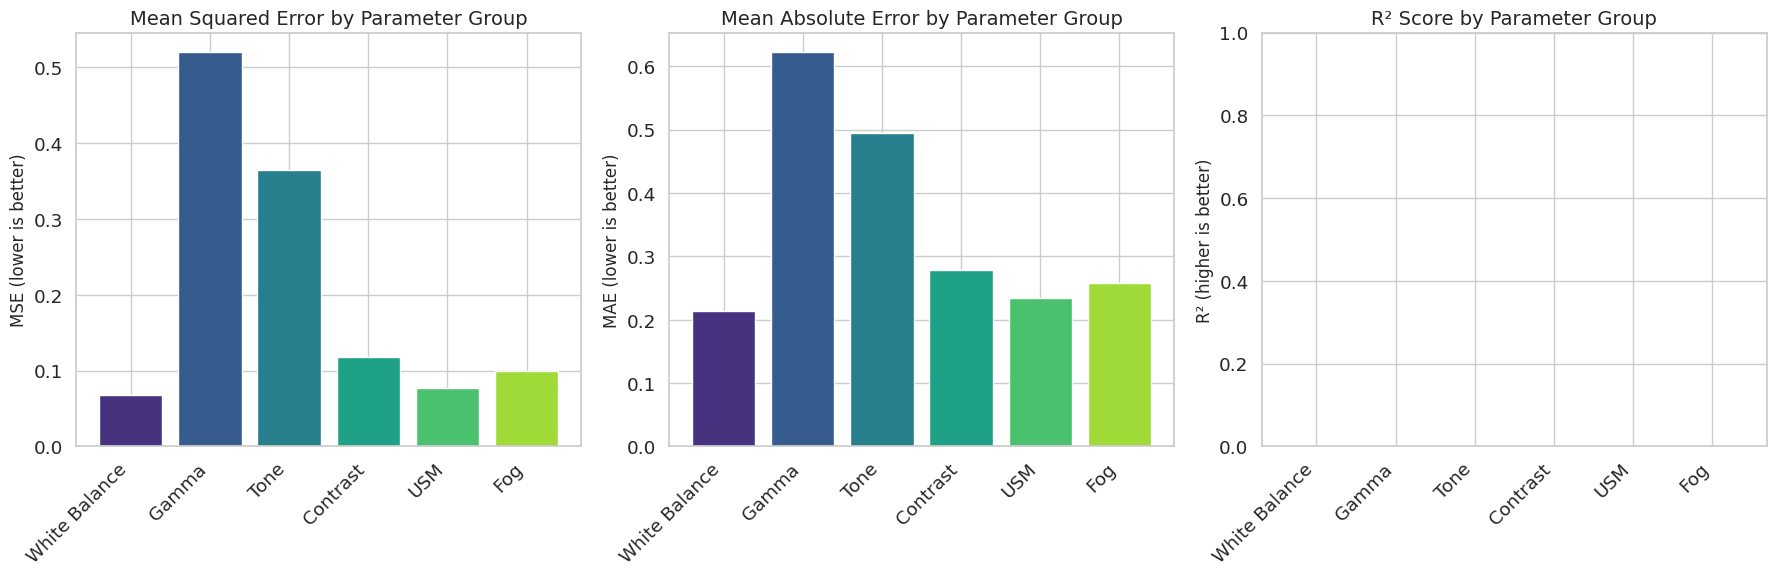

In [9]:
# Plot overall metrics by parameter group
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Convert metrics to DataFrames for easier plotting
mse_data = {group: metrics['MSE'] for group, metrics in overall_metrics.items()}
mae_data = {group: metrics['MAE'] for group, metrics in overall_metrics.items()}
r2_data = {group: metrics['R²'] for group, metrics in overall_metrics.items()}

# Set consistent color scheme
colors = sns.color_palette('viridis', len(overall_metrics))

# Plot MSE
axes[0].bar(mse_data.keys(), mse_data.values(), color=colors)
axes[0].set_title('Mean Squared Error by Parameter Group')
axes[0].set_ylabel('MSE (lower is better)')
axes[0].set_ylim(bottom=0)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot MAE
axes[1].bar(mae_data.keys(), mae_data.values(), color=colors)
axes[1].set_title('Mean Absolute Error by Parameter Group')
axes[1].set_ylabel('MAE (lower is better)')
axes[1].set_ylim(bottom=0)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

# Plot R²
axes[2].bar(r2_data.keys(), r2_data.values(), color=colors)
axes[2].set_title('R² Score by Parameter Group')
axes[2].set_ylabel('R² (higher is better)')
axes[2].set_ylim(bottom=0, top=1.0)
plt.setp(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('overall_metrics_by_group.png', dpi=300, bbox_inches='tight')
plt.show()

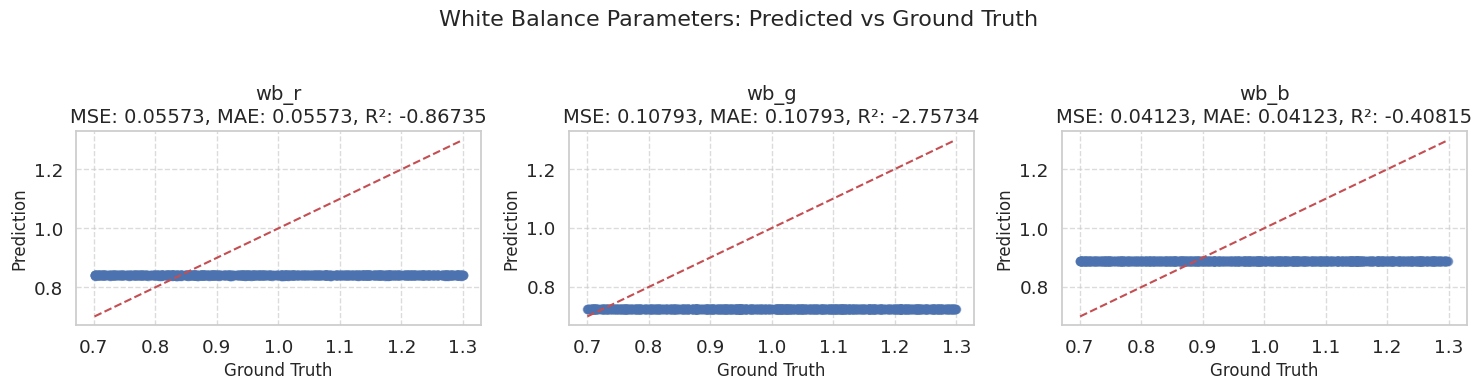

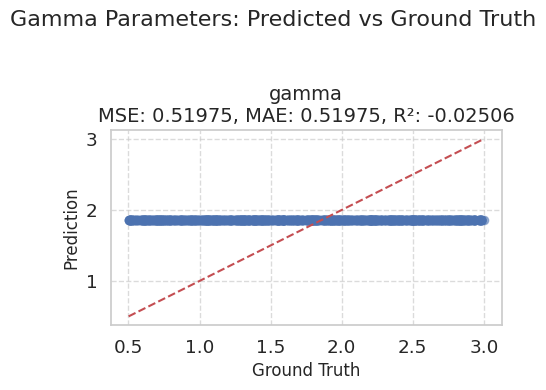

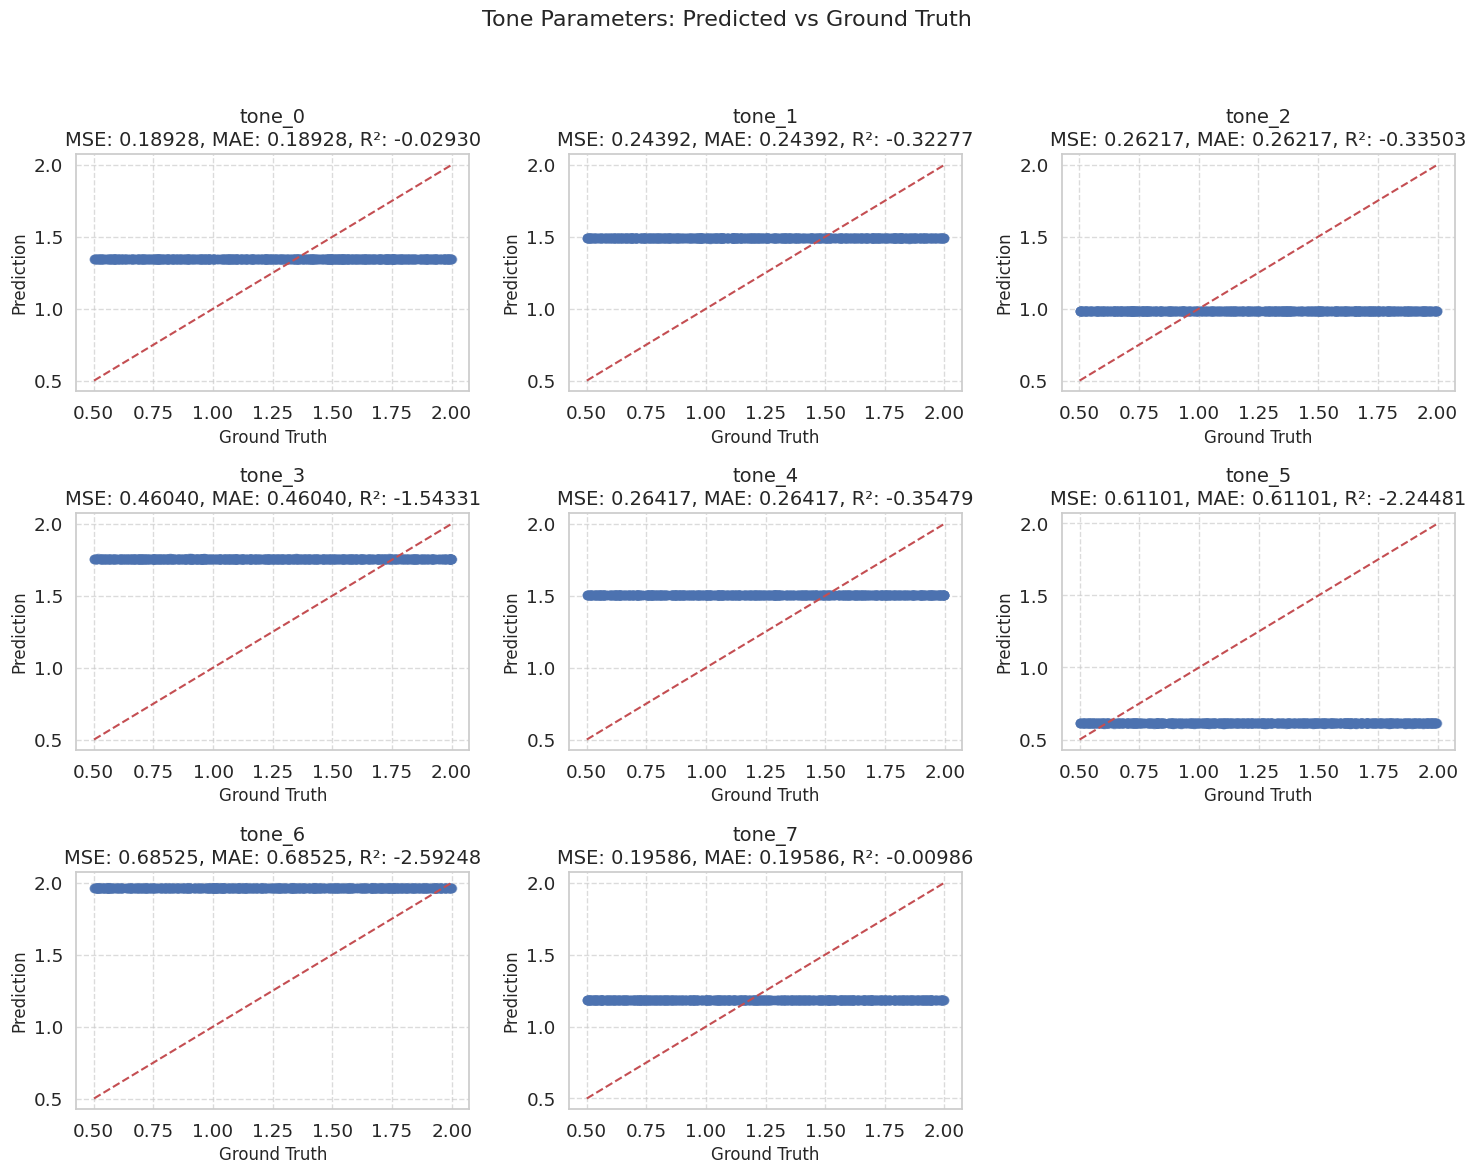

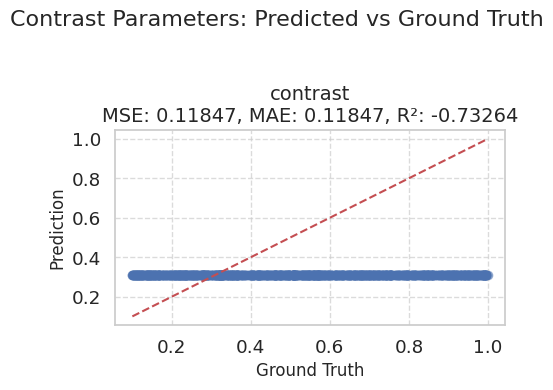

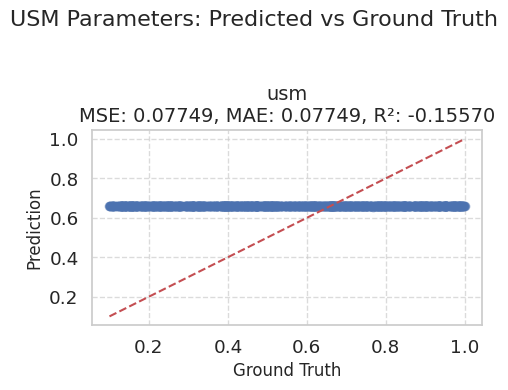

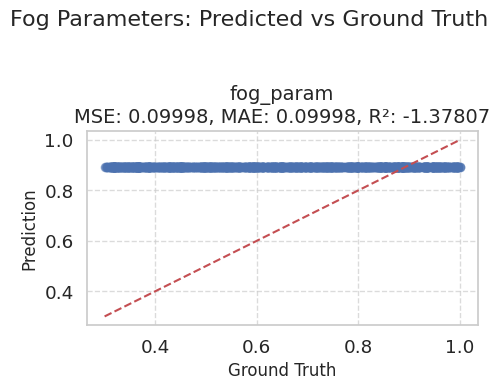

In [10]:
# Create scatter plots comparing predicted vs ground truth values
def create_scatter_plots(eval_df, parameter_groups):
    for group_name, params in parameter_groups.items():
        n_params = len(params)
        if n_params == 0:
            continue

        # Set rows and columns for subplots
        n_cols = min(3, n_params)
        n_rows = (n_params + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
        fig.suptitle(f'{group_name} Parameters: Predicted vs Ground Truth', fontsize=16)

        if n_params == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for i, param in enumerate(params):
            if param in eval_df.columns and f"{param}_pred" in eval_df.columns:
                ax = axes[i]

                # Get ground truth and predictions
                true_vals = eval_df[param]
                pred_vals = eval_df[f"{param}_pred"]

                # Calculate metrics
                mse = mean_squared_error(true_vals, pred_vals)
                mae = mean_absolute_error(true_vals, pred_vals)
                r2 = r2_score(true_vals, pred_vals)

                # Create scatter plot
                ax.scatter(true_vals, pred_vals, alpha=0.5)

                # Add perfect prediction line
                min_val = min(true_vals.min(), pred_vals.min())
                max_val = max(true_vals.max(), pred_vals.max())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--')

                # Set labels and title
                ax.set_xlabel('Ground Truth')
                ax.set_ylabel('Prediction')
                ax.set_title(f'{param}\nMSE: {mse:.5f}, MAE: {mse:.5f}, R²: {r2:.5f}')

                # Add grid
                ax.grid(True, linestyle='--', alpha=0.7)

        # Hide any unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
        plt.savefig(f'{group_name}_scatter_plots.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create scatter plots for each parameter group
create_scatter_plots(eval_df, parameter_groups)

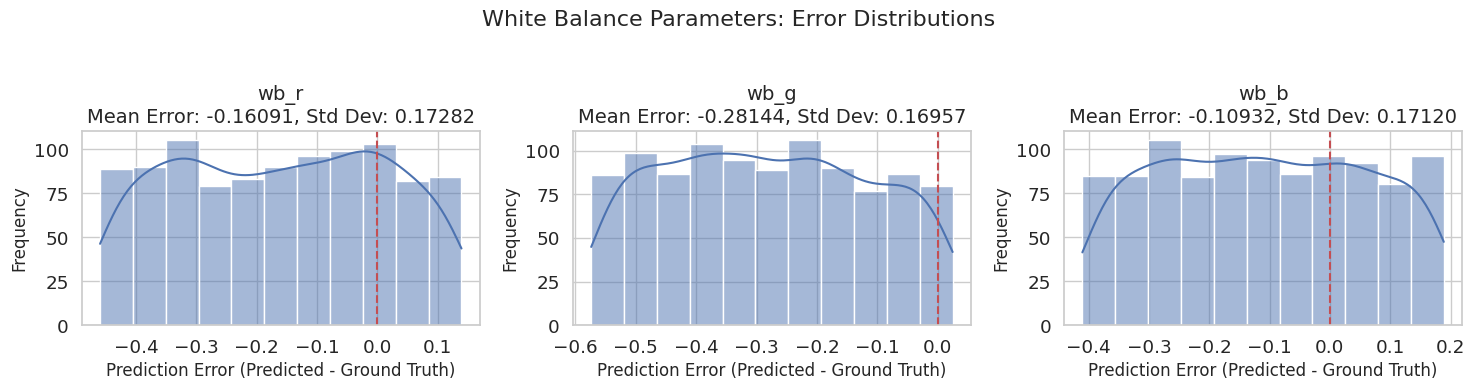

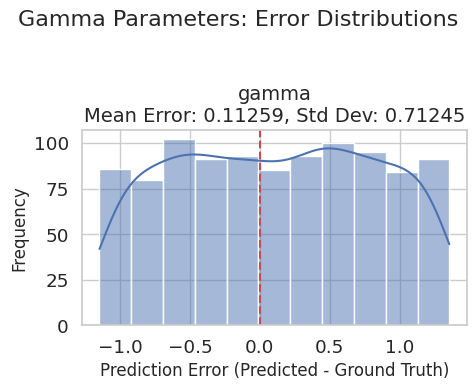

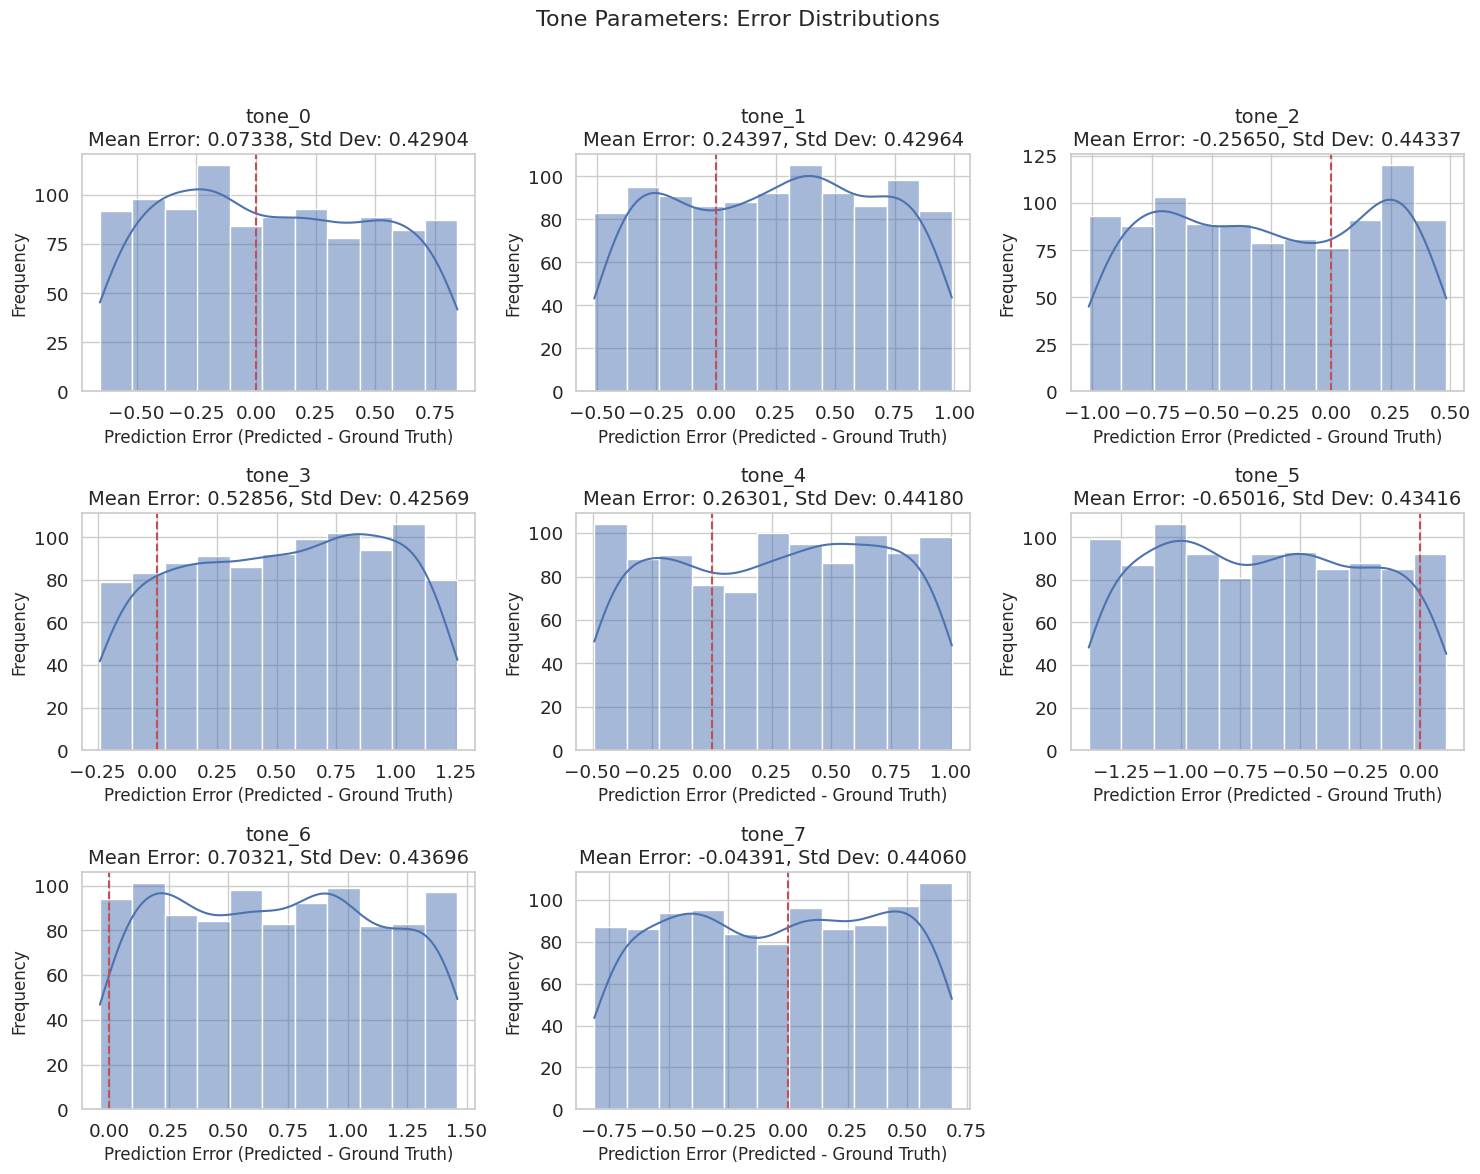

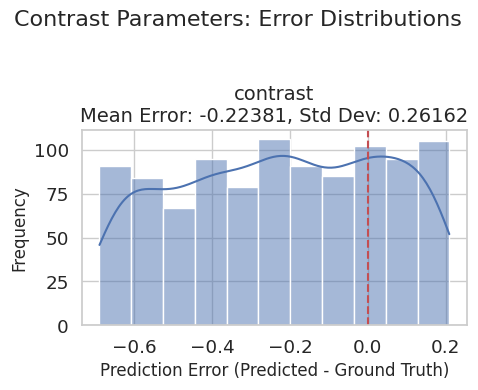

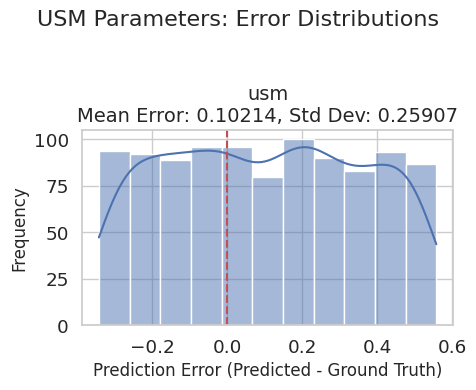

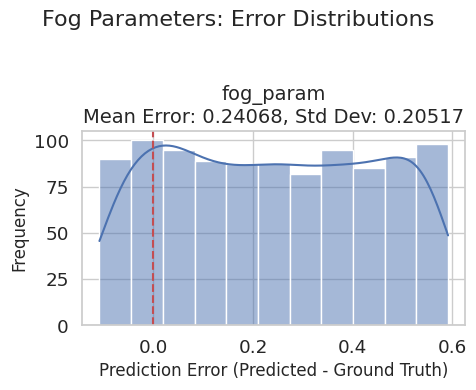

In [11]:
# Plot error distributions as histograms
def plot_error_distributions(eval_df, parameter_groups):
    for group_name, params in parameter_groups.items():
        n_params = len(params)
        if n_params == 0:
            continue

        # Set rows and columns for subplots
        n_cols = min(3, n_params)
        n_rows = (n_params + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
        fig.suptitle(f'{group_name} Parameters: Error Distributions', fontsize=16)

        if n_params == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for i, param in enumerate(params):
            if param in eval_df.columns and f"{param}_pred" in eval_df.columns:
                ax = axes[i]

                # Calculate errors
                errors = eval_df[f"{param}_pred"] - eval_df[param]

                # Plot histogram
                sns.histplot(errors, kde=True, ax=ax)

                # Add vertical line at zero
                ax.axvline(x=0, color='r', linestyle='--')

                # Set labels and title
                ax.set_xlabel('Prediction Error (Predicted - Ground Truth)')
                ax.set_ylabel('Frequency')
                ax.set_title(f'{param}\nMean Error: {errors.mean():.5f}, Std Dev: {errors.std():.5f}')

        # Hide any unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
        plt.savefig(f'{group_name}_error_distributions.png', dpi=300, bbox_inches='tight')
        plt.show()

# Plot error distributions
plot_error_distributions(eval_df, parameter_groups)

In [12]:
# Visualize predictions on sample test images with side-by-side comparisons
def visualize_sample_predictions(eval_df, test_dir, num_samples=5):
    # Select random samples from the evaluation set
    samples = eval_df.sample(num_samples)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(test_dir, row['filename'])

        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        # Load and display the original image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create a figure to display image and parameter comparison
        fig = plt.figure(figsize=(15, 10))
        grid = plt.GridSpec(2, 3, figure=fig)

        # Plot the image
        ax_img = fig.add_subplot(grid[0, :])
        ax_img.imshow(img)
        ax_img.set_title(f"Test Image: {row['filename']}")
        ax_img.axis('off')

        # Plot parameter comparisons
        ax_wb = fig.add_subplot(grid[1, 0])
        ax_gamma_tone = fig.add_subplot(grid[1, 1])
        ax_other = fig.add_subplot(grid[1, 2])

        # White balance parameters
        wb_true = [row['wb_r'], row['wb_g'], row['wb_b']]
        wb_pred = [row['wb_r_pred'], row['wb_g_pred'], row['wb_b_pred']]

        ax_wb.bar(["R", "G", "B"], wb_true, alpha=0.7, label='Ground Truth')
        ax_wb.bar(["R", "G", "B"], wb_pred, alpha=0.7, label='Predicted')
        ax_wb.set_title('White Balance Parameters')
        ax_wb.set_ylim(0.6, 1.4)  # Typical range for WB params
        ax_wb.legend()

        # Gamma and tone parameters
        params_gt = ['gamma'] + [f'tone_{i}' for i in range(4)]  # Show first 4 tone params to avoid crowding
        params_pred = ['gamma_pred'] + [f'tone_{i}_pred' for i in range(4)]

        values_gt = [row[p] for p in params_gt]
        values_pred = [row[p] for p in params_pred]

        x = np.arange(len(params_gt))
        width = 0.35

        ax_gamma_tone.bar(x - width/2, values_gt, width, label='Ground Truth')
        ax_gamma_tone.bar(x + width/2, values_pred, width, label='Predicted')
        ax_gamma_tone.set_xticks(x)
        ax_gamma_tone.set_xticklabels(params_gt)
        ax_gamma_tone.set_title('Gamma and Tone Parameters')
        ax_gamma_tone.legend()

        # Other parameters (contrast, usm, fog)
        other_params_gt = ['contrast', 'usm', 'fog_param']
        other_params_pred = ['contrast_pred', 'usm_pred', 'fog_param_pred']

        other_values_gt = [row[p] for p in other_params_gt]
        other_values_pred = [row[p] for p in other_params_pred]

        x = np.arange(len(other_params_gt))

        ax_other.bar(x - width/2, other_values_gt, width, label='Ground Truth')
        ax_other.bar(x + width/2, other_values_pred, width, label='Predicted')
        ax_other.set_xticks(x)
        ax_other.set_xticklabels(['Contrast', 'USM', 'Fog'])
        ax_other.set_title('Other Parameters')
        ax_other.legend()

        plt.tight_layout()
        plt.savefig(f'sample_prediction_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Visualize predictions on a few sample images
visualize_sample_predictions(eval_df, TEST_DATA_DIR, num_samples=5)

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-13-1bbb82fc482d>:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_errors = eval_df.groupby('bin').apply(
<ipython-input-13-1bbb82fc482d>:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_errors = eval_df.groupby('bin').apply(
<ipython-input-13-1bbb82fc482d>:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

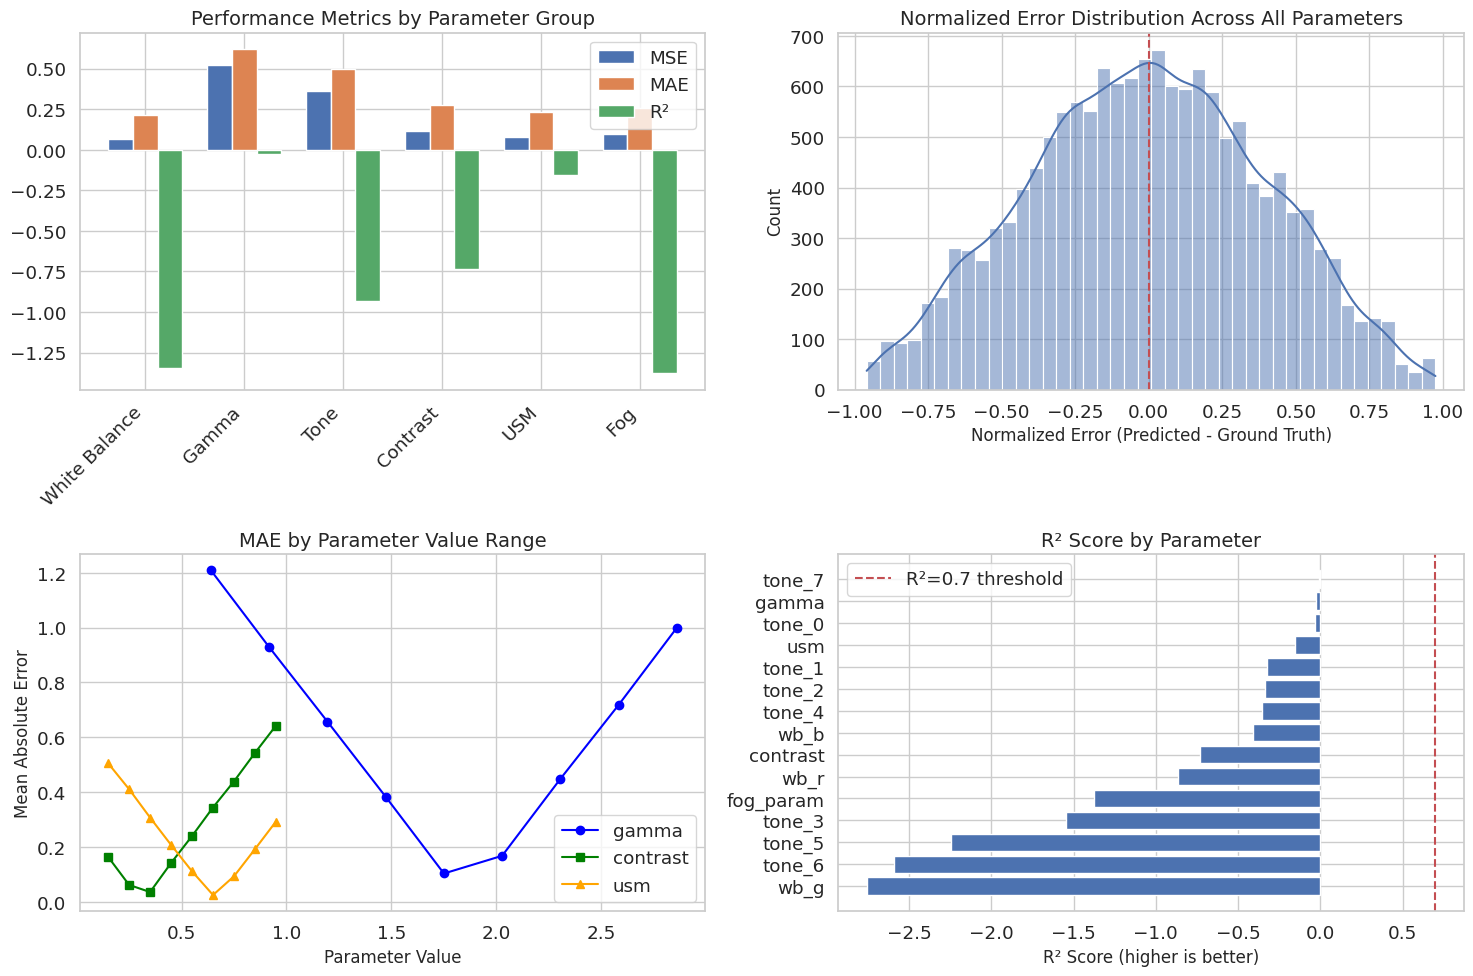

In [13]:
# Create a summary dashboard showing overall performance
def create_performance_dashboard(eval_df, overall_metrics):
    # Create figure and grid
    fig = plt.figure(figsize=(15, 10))
    grid = plt.GridSpec(2, 2, figure=fig)

    # Plot overall metrics by parameter group
    ax_metrics = fig.add_subplot(grid[0, 0])

    groups = list(overall_metrics.keys())
    x = np.arange(len(groups))
    width = 0.25

    mse_values = [metrics['MSE'] for metrics in overall_metrics.values()]
    mae_values = [metrics['MAE'] for metrics in overall_metrics.values()]
    r2_values = [metrics['R²'] for metrics in overall_metrics.values()]

    ax_metrics.bar(x - width, mse_values, width, label='MSE')
    ax_metrics.bar(x, mae_values, width, label='MAE')
    ax_metrics.bar(x + width, r2_values, width, label='R²')

    ax_metrics.set_xticks(x)
    ax_metrics.set_xticklabels(groups, rotation=45, ha='right')
    ax_metrics.set_title('Performance Metrics by Parameter Group')
    ax_metrics.legend()

    # Plot average error distribution across all parameters
    ax_error = fig.add_subplot(grid[0, 1])

    all_errors = []
    for group_name, params in parameter_groups.items():
        for param in params:
            if param in eval_df.columns and f"{param}_pred" in eval_df.columns:
                errors = eval_df[f"{param}_pred"] - eval_df[param]
                # Normalize errors by parameter range to make them comparable
                param_range = eval_df[param].max() - eval_df[param].min()
                if param_range > 0:
                    normalized_errors = errors / param_range
                    all_errors.extend(normalized_errors)

    sns.histplot(all_errors, kde=True, ax=ax_error)
    ax_error.axvline(x=0, color='r', linestyle='--')
    ax_error.set_title('Normalized Error Distribution Across All Parameters')
    ax_error.set_xlabel('Normalized Error (Predicted - Ground Truth)')

    # Plot performance over parameter ranges
    ax_ranges = fig.add_subplot(grid[1, 0])

    # Pick a few important parameters to analyze
    key_params = ['gamma', 'contrast', 'usm']
    markers = ['o', 's', '^']
    colors = ['blue', 'green', 'orange']

    for i, param in enumerate(key_params):
        if param in eval_df.columns and f"{param}_pred" in eval_df.columns:
            # Group by parameter value range and calculate average error
            # Create 10 bins across parameter range
            bins = np.linspace(eval_df[param].min(), eval_df[param].max(), 10)
            eval_df['bin'] = pd.cut(eval_df[param], bins)

            # Calculate average absolute error for each bin
            bin_errors = eval_df.groupby('bin').apply(
                lambda x: mean_absolute_error(x[param], x[f"{param}_pred"])
            ).reset_index()

            # Plot bin midpoints vs errors
            bin_centers = [(b.left + b.right) / 2 for b in bin_errors['bin']]
            ax_ranges.plot(bin_centers, bin_errors[0], marker=markers[i], color=colors[i], label=param)

            # Remove the temporary bin column
            eval_df.drop('bin', axis=1, inplace=True)

    ax_ranges.set_title('MAE by Parameter Value Range')
    ax_ranges.set_xlabel('Parameter Value')
    ax_ranges.set_ylabel('Mean Absolute Error')
    ax_ranges.legend()

    # Plot r² for all parameters as a horizontal bar chart
    ax_r2 = fig.add_subplot(grid[1, 1])

    all_params = []
    all_r2s = []

    for group_name, params in parameter_groups.items():
        for param in params:
            if param in eval_df.columns and f"{param}_pred" in eval_df.columns:
                y_true = eval_df[param]
                y_pred = eval_df[f"{param}_pred"]
                r2 = r2_score(y_true, y_pred)

                all_params.append(param)
                all_r2s.append(r2)

    # Sort by R² value
    sorted_indices = np.argsort(all_r2s)
    sorted_params = [all_params[i] for i in sorted_indices]
    sorted_r2s = [all_r2s[i] for i in sorted_indices]

    ax_r2.barh(sorted_params, sorted_r2s)
    ax_r2.set_title('R² Score by Parameter')
    ax_r2.set_xlabel('R² Score (higher is better)')
    ax_r2.axvline(x=0.7, color='r', linestyle='--', label='R²=0.7 threshold')
    ax_r2.legend()

    plt.tight_layout()
    plt.savefig('performance_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create the performance dashboard
create_performance_dashboard(eval_df, overall_metrics)

In [14]:
# Save evaluation results to CSV files for future reference
eval_df.to_csv('model_evaluation_results.csv', index=False)

# Create a summary DataFrame of overall metrics
summary_data = []
for group_name, metrics in overall_metrics.items():
    row = {'Parameter Group': group_name}
    row.update(metrics)
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('model_evaluation_summary.csv', index=False)

print("Evaluation results saved to CSV files.")
print("Complete evaluation process finished successfully!")

Evaluation results saved to CSV files.
Complete evaluation process finished successfully!
